In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets 
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np 

from datetime import datetime

# 1. Download the Dataset

In [3]:
import torchvision.transforms as transforms

transforms = transforms.Compose([transforms.Resize((256,256)),
                                 transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(60),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))])


train_dataset = datasets.MNIST(root='.',
                                      train=True,
                                      download = True,
                                      transform = transforms)

valid_dataset = datasets.MNIST(root='.',
                                      train=False,
                                      transform=transforms)

# 2.   Prepare the Dataloader



In [4]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Visualise the Dataset

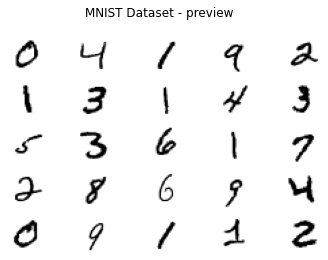

In [6]:
ROW_IMG = 5
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG*N_ROWS + 1):
    plt.subplot(N_ROWS,ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

#4. Modified MNIST-Resnet Architecture (19K Params)

In [5]:
class MNIST_RESNET(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, layers, channels = config
        self.in_channels = channels[0]
            
        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])
        
        self.conv1 = nn.Conv2d(1, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [6]:
class Identity(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        
    def forward(self, x):
        return self.f(x)
        

class MNISTBasicBlock(nn.Module):
        
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            identity_fn = lambda x : F.pad(x[:, :, ::2, ::2], 
                                           [0, 0, 0, 0, in_channels // 2, in_channels // 2])
            downsample = Identity(identity_fn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                                
        x += i
        x = self.relu(x)
        
        return x

In [7]:
from collections import namedtuple

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [8]:
mnist_resnet_config = ResNetConfig(block = MNISTBasicBlock,
                                     n_blocks = [1, 1, 1],
                                     channels = [8, 16, 32])

In [9]:
OUTPUT_DIM = len(valid_dataset.classes)
OUTPUT_DIM

10

In [10]:
model = MNIST_RESNET(mnist_resnet_config, OUTPUT_DIM)

In [26]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), 
            nn.MaxPool2d(2), 
            nn.ReLU(inplace = True),
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True),
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.ReLU(inplace = True)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32 * 1 * 1, 10))
  

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [27]:
OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)

In [28]:
from torchsummary import summary
summary(model.cuda(), (1, 32, 32)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
         MaxPool2d-2             [-1, 32, 8, 8]               0
              ReLU-3             [-1, 32, 8, 8]               0
            Conv2d-4             [-1, 32, 8, 8]           9,248
         MaxPool2d-5             [-1, 32, 4, 4]               0
              ReLU-6             [-1, 32, 4, 4]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
 AdaptiveAvgPool2d-8             [-1, 32, 1, 1]               0
              ReLU-9             [-1, 32, 1, 1]               0
          Dropout-10                   [-1, 32]               0
           Linear-11                   [-1, 10]             330
Total params: 19,146
Trainable params: 19,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 19,146 trainable parameters


# Training the Model

In [11]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

## Learning Rate Finder

In [14]:
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler

In [28]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [45]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

In [30]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

We can see that the loss reaches a minimum at around $3x10^{-4}$.

A good learning rate to choose here would be the middle of the steepest downward curve - which is around $1.5x10^{-4}$

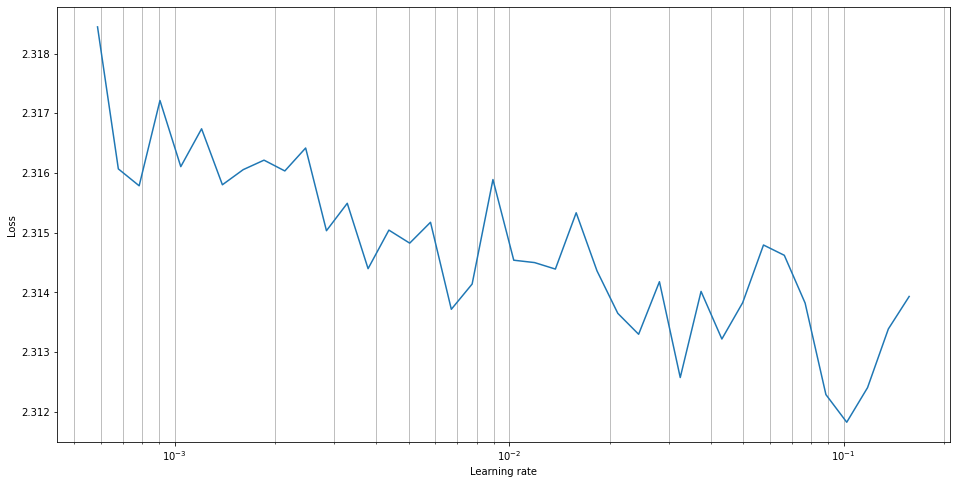

In [46]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [12]:
FOUND_LR = 3e-3

optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)


The one cycle learning rate cycles the momentum of the optimizer. The momentum is cycled from a maximum value, down to a minimum and then back up to the maximum where it is held constant for the last few steps. The default maximum and minimum values of momentum used by PyTorch's one cycle learning rate scheduler should be sufficient and we will not change them.

To set-up the one cycle learning rate scheduler we need the total number of steps that will occur during training. We simply get this by multiplying the number of epochs with the number of batches in the training iterator, i.e. number of parameter updates. We get the maximum learning rate for each parameter group and pass this to max_lr. Note: if you only pass a single learning rate and not a list of learning rates then the scheduler will assume this learning rate should be used for all parameters and will not do discriminative fine-tuning.

In [15]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [16]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

# Training-Validation functions

In [17]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def plot_acc(train_acc, valid_acc):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of plots to seaborn
    plt.style.use('seaborn')

    train_accs = np.array(train_acc)
    valid_accs = np.array(valid_acc)

    fig,ax = plt.subplots(figsize = (8,4.5))

    ax.plot(train_accs, color='blue', label='Training Acc')
    ax.plot(valid_accs, color='red', label='validation Acc')

    ax.set(title = 'Acc over epochs', xlabel='Epoch', ylabel='Acc')
    ax.legend()
    fig.show()

    # Change the plot style to default
    plt.style.use('default')

In [20]:
import time

EPOCHS = 30

best_valid_loss = float('inf')

train_accuracies = []
valid_accuracies = []

for epoch in range(EPOCHS):
    
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '19K-model.pt')

    
    print(f'Epoch: {epoch+1:02} ')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

Epoch: 01 
	Train Loss: 2.211 | Train Acc: 20.02%
	 Val. Loss: 2.268 |  Val. Acc: 11.65%
Epoch: 02 
	Train Loss: 2.054 | Train Acc: 27.71%
	 Val. Loss: 2.416 |  Val. Acc: 10.94%
Epoch: 03 
	Train Loss: 1.950 | Train Acc: 31.87%
	 Val. Loss: 3.472 |  Val. Acc: 14.30%
Epoch: 04 
	Train Loss: 1.873 | Train Acc: 35.99%
	 Val. Loss: 1.843 |  Val. Acc: 37.45%
Epoch: 05 
	Train Loss: 1.809 | Train Acc: 39.02%
	 Val. Loss: 3.552 |  Val. Acc: 14.90%
Epoch: 06 
	Train Loss: 1.752 | Train Acc: 41.49%
	 Val. Loss: 2.982 |  Val. Acc: 13.37%
Epoch: 07 
	Train Loss: 1.699 | Train Acc: 43.39%
	 Val. Loss: 4.799 |  Val. Acc: 12.11%
Epoch: 08 
	Train Loss: 1.652 | Train Acc: 44.96%
	 Val. Loss: 3.298 |  Val. Acc: 11.54%
Epoch: 09 
	Train Loss: 1.608 | Train Acc: 46.86%
	 Val. Loss: 1.582 |  Val. Acc: 46.74%
Epoch: 10 
	Train Loss: 1.567 | Train Acc: 47.98%
	 Val. Loss: 3.293 |  Val. Acc: 16.57%
Epoch: 11 
	Train Loss: 1.527 | Train Acc: 49.50%
	 Val. Loss: 3.427 |  Val. Acc: 11.07%
Epoch: 12 
	Train Los

<ipython-input-19-0b07497548bb>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


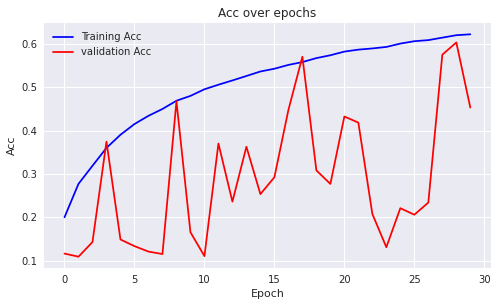

In [22]:
plot_acc(train_accuracies, valid_accuracies)

In [29]:
model.load_state_dict(torch.load('19K-model.pt'))

RuntimeError: Error(s) in loading state_dict for AlexNet:
	Missing key(s) in state_dict: "features.0.weight", "features.0.bias", "features.3.weight", "features.3.bias", "features.6.weight", "features.6.bias", "classifier.1.weight", "classifier.1.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "fc.weight", "fc.bias". 

In [82]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
EPOCHS = 40

best_valid_loss = float('98.9')

for epoch in range(EPOCHS):
    
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '19K-model-2.pt')

    
    print(f'Epoch: {epoch+1:02} ')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 
	Train Loss: 0.039 | Train Acc: 98.91%
	 Val. Loss: 0.044 |  Val. Acc: 98.88%
Epoch: 02 
	Train Loss: 0.039 | Train Acc: 98.90%
	 Val. Loss: 0.044 |  Val. Acc: 98.90%
Epoch: 03 
	Train Loss: 0.039 | Train Acc: 98.89%
	 Val. Loss: 0.044 |  Val. Acc: 98.92%
Epoch: 04 
	Train Loss: 0.039 | Train Acc: 98.90%
	 Val. Loss: 0.045 |  Val. Acc: 98.90%
Epoch: 05 
	Train Loss: 0.039 | Train Acc: 98.91%
	 Val. Loss: 0.044 |  Val. Acc: 98.93%
Epoch: 06 
	Train Loss: 0.038 | Train Acc: 98.94%
	 Val. Loss: 0.044 |  Val. Acc: 98.93%
Epoch: 07 
	Train Loss: 0.039 | Train Acc: 98.92%
	 Val. Loss: 0.044 |  Val. Acc: 98.91%
Epoch: 08 
	Train Loss: 0.040 | Train Acc: 98.89%
	 Val. Loss: 0.044 |  Val. Acc: 98.91%
Epoch: 09 
	Train Loss: 0.039 | Train Acc: 98.93%
	 Val. Loss: 0.044 |  Val. Acc: 98.90%
Epoch: 10 
	Train Loss: 0.040 | Train Acc: 98.92%
	 Val. Loss: 0.044 |  Val. Acc: 98.92%
Epoch: 11 
	Train Loss: 0.039 | Train Acc: 98.91%
	 Val. Loss: 0.044 |  Val. Acc: 98.90%


In [ ]:
plot_losses(train_losses, valid_losses)
